In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx

### specify directory where data is stored

In [3]:
#use this path for personal computer
diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
#diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Pooled Differential Gene Expression/"

### set parameters for plotting

In [ ]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

## *Function* for constructing distribution of edge weights from pooled (significant) logFC changes across datasets

In [31]:
def edge_weight_distribution_from_pooled_logFC(logFC_table_filename):

    # read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
    diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
    diff_gene_exp_df.rename_axis('gene' , inplace = True)

    # Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
    # +1 if logFC > 0
    # 0 if logFC = 0
    # -1 if logFC < 0

    # store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
    direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

    # replace values in logFC matrix
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

    # convert to lower memory int8 datatype
    direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

    # compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
    # multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
    network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

    # the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
    network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

    # retrieve the distribution of the Edge Weights
    # return the upper triangular part of the matrix with elements in lower part zeroed out
    upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

    #Return all non-zero elements
    edge_weight_array = upper_tri_network_edge_weight_matrix[np.nonzero(upper_tri_network_edge_weight_matrix)]
    
    return edge_weight_array

## *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [104]:
def plot_distribution_of_edge_weights(ax, edge_weight_array, plot_title):
    
    n , bins , patches = ax.hist(edge_weight_array , bins = np.arange(np.min(edge_weight_array), np.max(edge_weight_array) + 1.5) , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.25 , align = 'left')

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Number of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel('Edge Weights' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

# ATB v LTBI

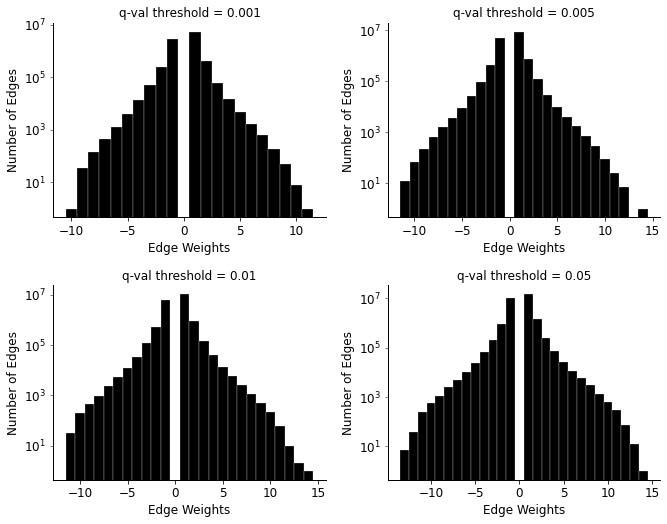

In [105]:
comparison_X = 'ATB_v_LTBI'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# ATB v HC

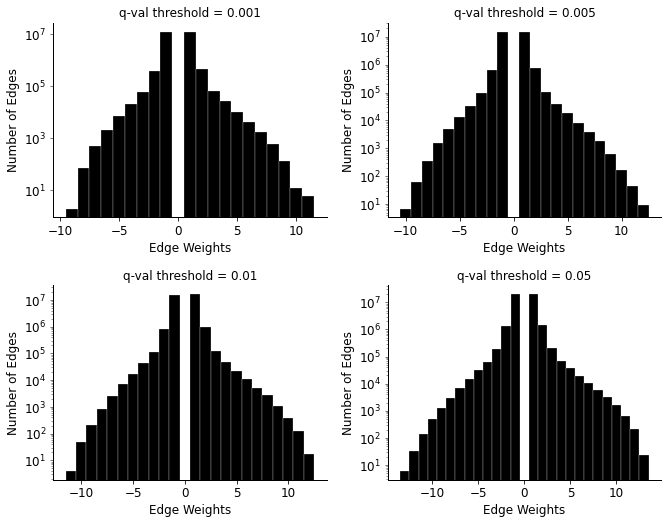

In [106]:
comparison_X = 'ATB_v_HC'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# ATB v OD

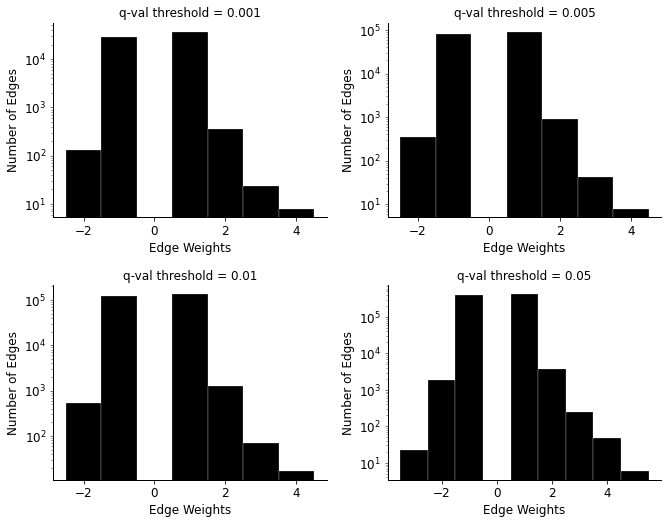

In [107]:
comparison_X = 'ATB_v_OD'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# LTBI v HC

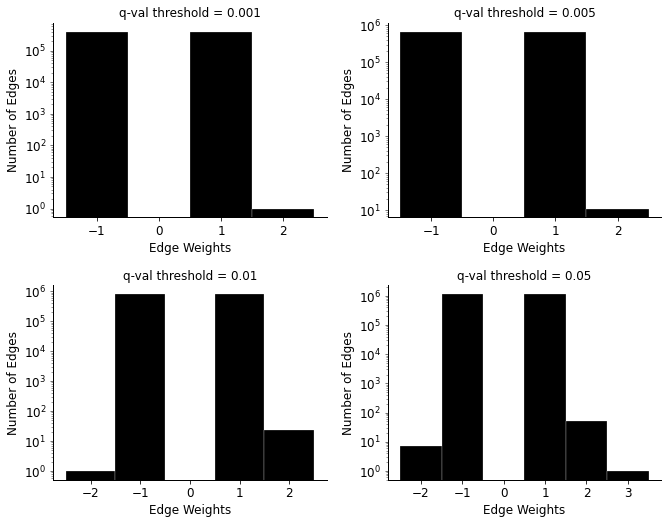

In [108]:
comparison_X = 'LTBI_v_HC'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_array, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_array = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_array, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()